
- [1] https://keras.io/examples/vision/conv_lstm/
- [2] https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7
- The data is available [here](https://drive.google.com/file/d/1ABJY2gfEocPfFg7yzjOOnRF9h_ZW7xtC/view?usp=sharing)

# Next Frame Video Prediction with Convolutional LSTMs

In this examples, we will learn about convolutional lstm models can be applied for next-frame video prediction, given a series of past frames. 

## Introduction to Convolutional LSTMs

When working with images, the best approach is a CNN (Convolutional Neural Network). However, when dealing with sequenital images, one approach is to use convolutional LSTM layers. This is a recurrent layer but instead of matrix multiplication convolutional operations are used. [2]

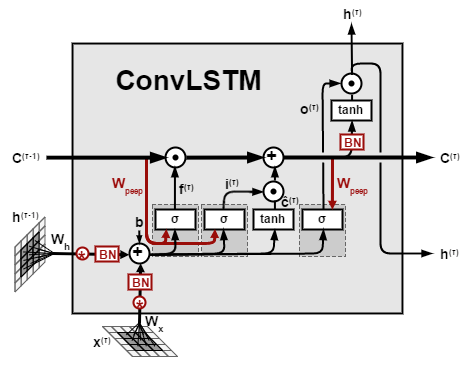

## **Convolutional LSTM layer INPUT** 

(samples, nframes, width, height, channels)


## **Convolutional LSTM layer OUTPUT** 

 (samples, nframes, rows, cols, filters)

## Other Paramters:
- Filters: the number of output filters in the convolution.
- kernel_size: height and width of the convolutional windows.
- padding: 'valid' or 'same'
- data_format: if channel comes first (channels_first) or last (channels_last)

# Setup

In [1]:
!pip install --upgrade pip
!pip install imageio 

     |████████████████████████████████| 1.7 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 3.3 MB 2.8 MB/s            
     |████████████████████████████████| 3.3 MB 2.0 MB/s             
     |████████████████████████████████| 3.1 MB 1.5 MB/s            
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.1
    Uninstalling Pillow-8.3.1:
      Successfully uninstalled Pillow-8.3.1


In [20]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

# Data Construction & Preprocessing

This example uses the [Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/) dataset which contains 10,000 sequences each of length 20 showing 2 digits moving in a 64x64 frame [3]

First we will load the training set and then preprocess the training and validation sets. 

In [3]:
#load the dataset in current directory ('mnist_moving.npy').
dataset = np.load('mnist_moving.npy')

In [4]:
print('convlstm input: (nsamples, nframes, height, width, channels)')

convlstm input: (nsamples, nframes, height, width, channels)


In [5]:
print('dataset shape:', dataset.shape)

dataset shape: (1000, 20, 64, 64, 1)


Split the dataset into training and validation sets 90\% for training 10\% for validation

In [6]:
#randomize indexes
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)

#assign 90% of samples to training and remaining 10% for validation
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]):]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

normalize the data so that all values are between 0-1

In [7]:
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

For next frame video prediction, our model will use a previous frame ($f_n$) to predict a new frame ($f_{n+1})$. To do this we must process the data in a way such that we have "shifted" inputs and outputs, where the input frame $x_n$ is used to predict the output frame $y_{n+1}$

In [8]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


In [9]:
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

In [10]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


# Data Visualization 

Our data consists of sequences of frames, each of which are used to predict the upcoming frame. Let's take a look at some of these sequential frames.

Displaying frames for example 526.


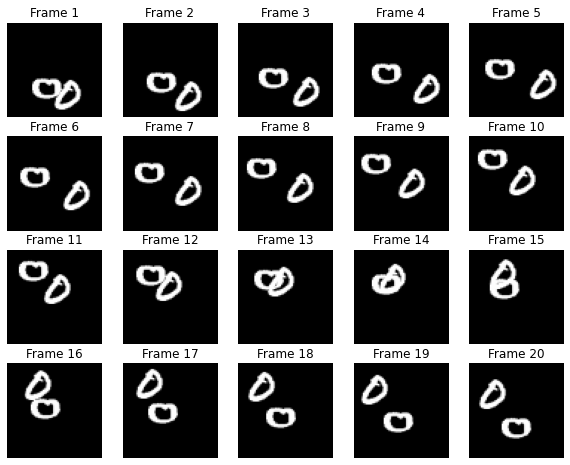

In [11]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()


# Model Construction

To build a Convolutional LSTM model, we will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.

In [15]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

In [16]:
# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

# Model Training

In [21]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint('mnist_moving.hdf5', mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)
# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr],
)


Epoch 1/20
180/180 [==============================] - 47s 224ms/step - loss: 0.1084 - val_loss: 0.2489
Epoch 2/20
180/180 [==============================] - 40s 225ms/step - loss: 0.0287 - val_loss: 0.1807
Epoch 3/20
180/180 [==============================] - 41s 228ms/step - loss: 0.0269 - val_loss: 0.1000
Epoch 4/20
180/180 [==============================] - 41s 230ms/step - loss: 0.0264 - val_loss: 0.0430
Epoch 5/20
180/180 [==============================] - 42s 232ms/step - loss: 0.0260 - val_loss: 0.0292
Epoch 6/20
180/180 [==============================] - 42s 236ms/step - loss: 0.0256 - val_loss: 0.0275
Epoch 7/20
180/180 [==============================] - 44s 245ms/step - loss: 0.0253 - val_loss: 0.0268
Epoch 8/20
180/180 [==============================] - 43s 238ms/step - loss: 0.0250 - val_loss: 0.0266
Epoch 9/20
180/180 [==============================] - 43s 238ms/step - loss: 0.0250 - val_loss: 0.0257
Epoch 10/20
180/180 [==============================] - 43s 239ms/step - l

# Frame Predictions Visualizations

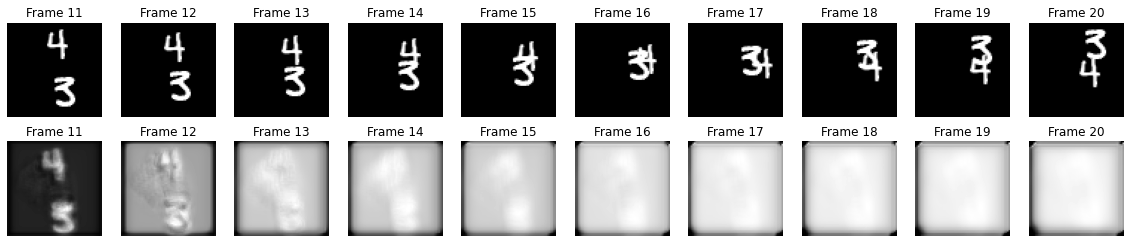

In [25]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for ii in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()


In [26]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)


 Truth	Prediction
